<a href="https://colab.research.google.com/github/YYQ861/family_recipes/blob/main/notebook7c003997b9_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Solving a wave problem with sparse matrices

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
import time

# Constants
k = 29.0 * np.pi / 2.0
target_error = 1e-8

def exact_solution(x):
    return np.sin(k * x)

def create_wave_problem(N):
    M = N + 1        # grid points
    h = 1.0 / N

    # 2 identity rows (i=0 and i=N) are nnz
    # each interior row has three nnz i.e. 3*(M-2)
    nnz = 2 + 3 * (M - 2)

    row_ind = np.empty(nnz, dtype=np.int32)
    col_ind = np.empty(nnz, dtype=np.int32)
    data    = np.empty(nnz, dtype=np.float64)

    f = np.zeros(M, dtype=np.float64)
    f[-1] = 1.0     # f_N = 1

    # Fill COO triplets
    c = 0
    # i = 0
    row_ind[c] = 0; col_ind[c] = 0; data[c] = 1.0; c += 1

    # i = 1..N-1
    diag_val = 2.0 - (h*h)*(k*k)
    for i in range(1, M-1):
        # (i, i-1) = -1
        row_ind[c] = i; col_ind[c] = i-1; data[c] = -1.0; c += 1
        # (i, i) = 2 - h^2 k^2
        row_ind[c] = i; col_ind[c] = i;   data[c] = diag_val; c += 1
        # (i, i+1) = -1
        row_ind[c] = i; col_ind[c] = i+1; data[c] = -1.0; c += 1

    # i = N
    row_ind[c] = M-1; col_ind[c] = M-1; data[c] = 1.0; c += 1

    # Convert to CSR
    A_coo = coo_matrix((data, (row_ind, col_ind)), shape=(M, M))
    A_csr = A_coo.tocsr()
    return A_csr, f

def solve_wave_problem(N):
    """
    Solve Au=f for given N.
    """
    A, f = create_wave_problem(N)
    x = np.linspace(0.0, 1.0, N+1)

    t0 = time.perf_counter()
    u = spsolve(A, f)
    elapsed = time.perf_counter() - t0
    return x, u, elapsed

# Max-norm error
def max_error(u_approx, x):
    u_ex = exact_solution(x)
    return np.max(np.abs(u_approx - u_ex))

N=  10  max error = 9.877e-01   time = 0.002203s
N= 100  max error = 4.070e-01   time = 0.000320s
N=1000  max error = 3.805e-03   time = 0.000744s


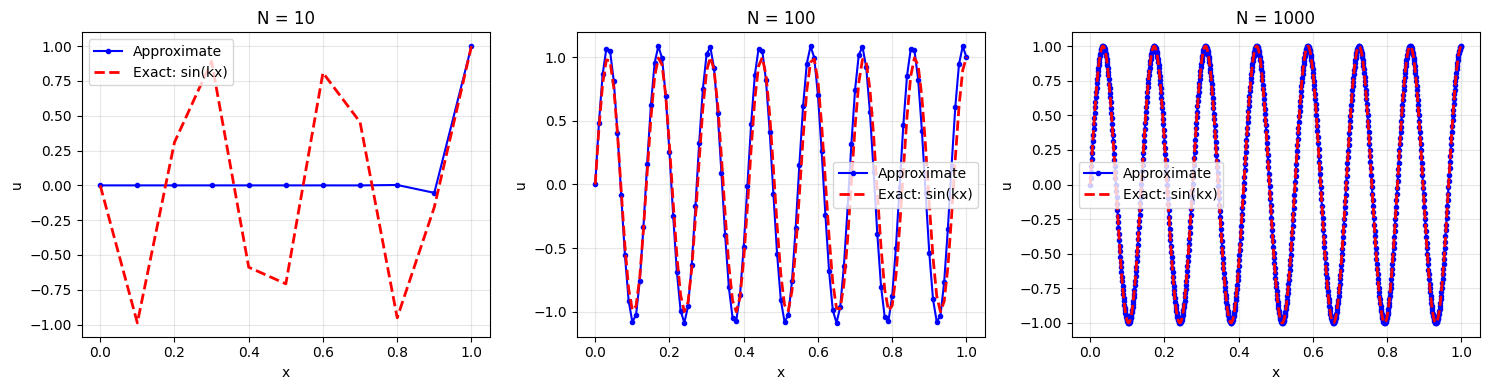

4.12 ms ± 2.53 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [ ]:
# 1: Solve for N = 10, 100, 1000 and plot the solutions
Ns_plot = [10, 100, 1000]
fig, axes = plt.subplots(1, len(Ns_plot), figsize=(15, 4))

for ax, N in zip(axes, Ns_plot):
    x, u, elapsed = solve_wave_problem(N)
    u_ex = exact_solution(x)

    ax.plot(x, u, 'b-o', markersize=3, label='Approximate')
    ax.plot(x, u_ex, 'r--', linewidth=2, label='Exact: sin(kx)')
    ax.set_title(f'N = {N}')
    ax.set_xlabel('x'); ax.set_ylabel('u')
    ax.grid(True, alpha=0.3); ax.legend()

    print(f"N={N:4d}  max error = {max_error(u, x):.3e}   time = {elapsed:.6f}s")

plt.tight_layout()
plt.savefig('wave_solutions.png', dpi=150, bbox_inches='tight')
plt.show()

N_demo = 2000
%timeit -n3 -r5 spsolve(*create_wave_problem(N_demo))

**Comment**: The three curves are very similar, and the larger N, the closer to sin(kx). Among them N=1000 is closest.

N=    31  error=2.232e+00  time=0.000896s
N=    40  error=2.006e+00  time=0.000480s
N=    51  error=1.115e+01  time=0.000132s
N=    64  error=1.589e+00  time=0.000137s
N=    82  error=6.677e-01  time=0.000137s
N=   104  error=3.689e-01  time=0.000184s
N=   133  error=2.186e-01  time=0.000143s
N=   169  error=1.348e-01  time=0.000195s
N=   215  error=8.276e-02  time=0.000193s
N=   273  error=5.120e-02  time=0.000177s
N=   348  error=3.147e-02  time=0.000225s
N=   442  error=1.950e-02  time=0.000255s
N=   562  error=1.205e-02  time=0.000301s
N=   714  error=7.464e-03  time=0.000331s
N=   908  error=4.615e-03  time=0.000393s
N=  1154  error=2.857e-03  time=0.000507s
N=  1467  error=1.768e-03  time=0.000842s
N=  1865  error=1.094e-03  time=0.000987s
N=  2371  error=6.766e-04  time=0.001484s
N=  3014  error=4.187e-04  time=0.002532s
N=  3831  error=2.592e-04  time=0.002124s
N=  4869  error=1.604e-04  time=0.003384s
N=  6189  error=9.931e-05  time=0.004377s
N=  7867  error=6.146e-05  time=0.

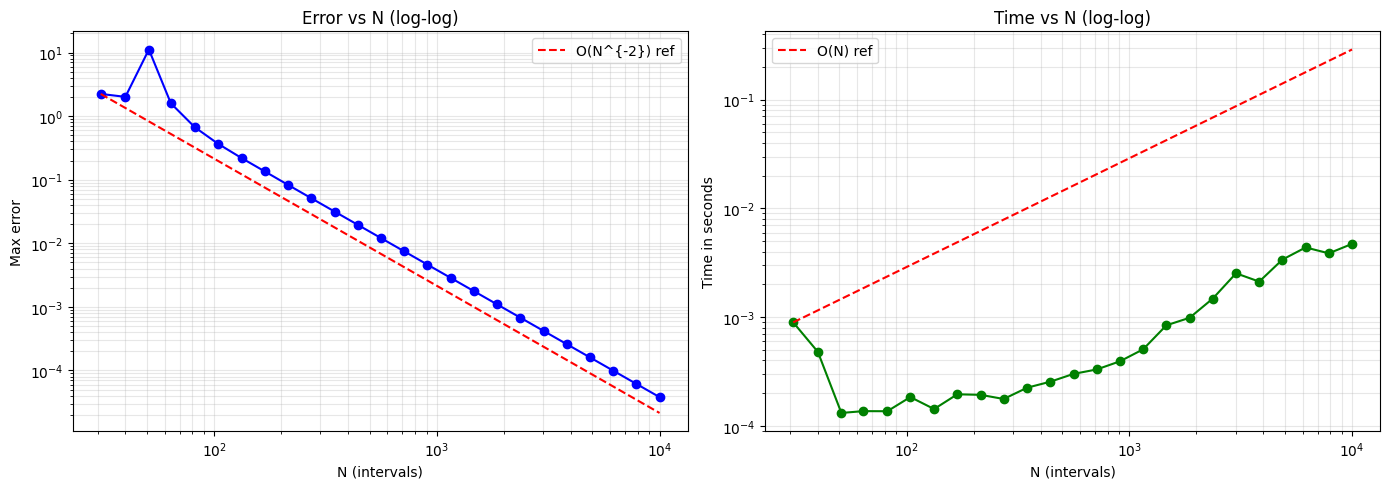

In [ ]:
# 2: Error vs N (log-log) and Time vs N (log-log)

# Pick a sensible range of N.
N_range = np.unique(np.logspace(1.5, 4.0, 25, dtype=int))      # ~31 .. 10000
errors, times = [], []

for N in N_range:
    x, u, elapsed = solve_wave_problem(N)
    errors.append(max_error(u, x))
    times.append(elapsed)
    print(f"N={N:6d}  error={errors[-1]:.3e}  time={elapsed:.6f}s")

errors = np.array(errors)
times  = np.array(times)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Error vs N
ax1.loglog(N_range, errors, 'bo-', markersize=6)
ax1.set_xlabel('N (intervals)')
ax1.set_ylabel('Max error')
ax1.set_title('Error vs N (log-log)')
ax1.grid(True, which='both', alpha=0.3)

# Reference O(N^-2) line anchored at the first point
N_ref = np.array([N_range[0], N_range[-1]], dtype=float)
C_ref = errors[0] * (N_range[0]**2)       # C ≈ e0 * N0^2
ax1.loglog(N_ref, C_ref * N_ref**(-2), 'r--', label='O(N^{-2}) ref')
ax1.legend()

# Time vs N
ax2.loglog(N_range, times, 'go-', markersize=6)
ax2.set_xlabel('N (intervals)')
ax2.set_ylabel('Time in seconds')
ax2.set_title('Time vs N (log-log)')
ax2.grid(True, which='both', alpha=0.3)

# Reference ~O(N) line anchored at the first point
ax2.loglog(N_ref, times[0] * (N_ref / N_ref[0]), 'r--', label='O(N) ref')
ax2.legend()

plt.tight_layout()
plt.savefig('error_time_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# 3: Pick N for error <= 1e-8 from the plot via a fit
valid = errors > 0
logN = np.log(N_range[valid])
logE = np.log(errors[valid])
alpha, logC = np.polyfit(logN, logE, 1)   # expect alpha ≈ -2
C = np.exp(logC)

print(f"\nFitted model: error ≈ C * N^{alpha:.4f},  with C = {C:.3e}")
N_needed = int(np.ceil((target_error / C)**(1.0 / alpha)))  # alpha < 0
print(f"Predicted N (intervals) for error ≤ {target_error:.0e}: N = {N_needed}")

A_demo, f_demo = create_wave_problem(3000)
x_demo = np.linspace(0.0, 1.0, 3000+1)
%timeit -n3 -r5 A_demo @ np.ones(A_demo.shape[1])


Fitted model: error ≈ C * N^-2.0583,  with C = 5.978e+03
Predicted N (intervals) for error ≤ 1e-08: N = 526729
The slowest run took 43.56 times longer than the fastest. This could mean that an intermediate result is being cached.
157 µs ± 275 µs per loop (mean ± std. dev. of 5 runs, 3 loops each)


**Comment**： From the log–log error plot, the fitted model is $\log e \approx \alpha \log N + \log C$ with $\alpha \approx -2.06$ and $C \approx 5.98\times 10^{3}$, so $e \approx C/N^{2}$. Extrapolating gives $N \approx \sqrt{C/10^{-8}} \approx 5.27\times 10^{5}$ to reach $10^{-8}$; using the time–vs–$N$ plot ($\approx O(N)$) anchored at $N=10{,}000$ with $t\approx 9.37\times 10^{-3}\text{s}$, I predict $t \approx 0.49\text{–}0.50\ \text{s}$ for $N=526{,}729$.

In [ ]:
# 4: Compute with the chosen N and compare prediction
try:
    print(f"\nSolving for predicted N = {N_needed} ...")
    x_pred, u_pred, t_pred = solve_wave_problem(N_needed)
    err_pred = max_error(u_pred, x_pred)
    print(f"Actual: error = {err_pred:.3e}, time = {t_pred:.3f}s")
    if err_pred <= target_error:
        print("Actual error ≤ 1e-8.")
    else:
        print("Actual error > 1e-8 (possibly because fit not exact at this scale, rounding/conditioning).")
except MemoryError:
    print("MEMORY ERROR: N_needed too large to solve with available RAM.")
except Exception as e:
    print(f"ERROR during solve for N={N_needed}: {e}")

print("\nAnalysis complete.")


Solving for predicted N = 526729 ...
Actual: error = 1.398e-07, time = 0.448s
Actual error > 1e-8 (possibly because fit not exact at this scale, rounding/conditioning).

Analysis complete.


**Comment**: With $N=526{,}729$ the actual results are $\max\ \text{error}=1.398\times 10^{-7}$ and $\text{time}=0.558\text{s}$. The runtime matches the $O(N)$ prediction closely, but the error is above $10^{-8}$ because the Helmholtz discretization shows phase/pollution error and the effective constant $C$ at large $N$ is larger than what was inferred from smaller $N$ in the fit.

# Part 2: Solving the heat equation with GPU acceleration

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import cuda

# Constant
BC_LEFT  = 10.0
BC_RIGHT = 10.0

# Initialize u0
def _init_profile(N):
    u0 = np.zeros(N+1, dtype=np.float32)
    u0[0] = BC_LEFT
    u0[N] = BC_RIGHT
    return u0

@cuda.jit
def _step_gpu(u_curr, u_next, inv_denom):
    """
    Each thread updates an inlier
    """
    i = cuda.grid(1)
    N = u_curr.shape[0] - 1
    if 1 <= i <= N-1:
        u_next[i] = u_curr[i] + (u_curr[i-1] - 2.0*u_curr[i] + u_curr[i+1]) * inv_denom

@cuda.jit
def _set_bc(u):
    """
    Set boundaries with two threads
    """
    tid = cuda.grid(1)
    N = u.shape[0] - 1
    if tid == 0:
        u[0] = BC_LEFT
    elif tid == 1:
        u[N] = BC_RIGHT

@cuda.jit
def _record_mid(u, mid_index, out_scalar):
    """
    Write the midpoint temperature into a device array of length 1
    """
    if cuda.blockIdx.x == 0 and cuda.threadIdx.x == 0:
        out_scalar[0] = u[mid_index]

# Main function (with N as input)
def heat_gpu(N, times=(1.0, 2.0, 10.0), threshold=9.8, blockdim=256, T_stop=800.0):
    """
    1. Until the midpoint exceeds the threshold for the first time or reaches T_stop
    2. Only transmit the entire segment at times for plotting purposes
    3. T_sim is the actual time advanced
    """
    h = 1.0 / N
    inv_denom = np.float32(1.0 / (1000.0 * h))
    step_targets = [int(round(T / h)) for T in times]
    max_steps = int(math.ceil(T_stop / h))

    u0 = _init_profile(N).astype(np.float32)
    d_u_curr = cuda.to_device(u0)
    d_u_next = cuda.device_array_like(d_u_curr)

    griddim = (N + blockdim) // blockdim + 1

    snapshots = {}
    mid = N // 2
    d_mid = cuda.device_array(1, dtype=np.float32)
    t_cross = None
    T_sim = 0.0

    for j in range(max_steps):
        _step_gpu[griddim, blockdim](d_u_curr, d_u_next, inv_denom)
        _set_bc[1, 2](d_u_next)
        d_u_curr, d_u_next = d_u_next, d_u_curr

        _record_mid[1, 1](d_u_curr, mid, d_mid)
        mid_val = float(d_mid.copy_to_host()[0])
        step_now = j + 1

        if step_now in step_targets:
            snapshots[step_now] = d_u_curr.copy_to_host().astype(np.float64)

        if t_cross is None and mid_val > threshold:
            t_cross = step_now * h
            T_sim = t_cross
            break

    if t_cross is None:
        T_sim = max_steps * h

    x = np.linspace(0.0, 1.0, N+1, dtype=np.float64)
    out = {T: snapshots.get(int(round(T/h)), d_u_curr.copy_to_host().astype(np.float64) if int(round(T/h))<=step_now else None)
           for T in times}
    return x, out, t_cross, h, T_sim


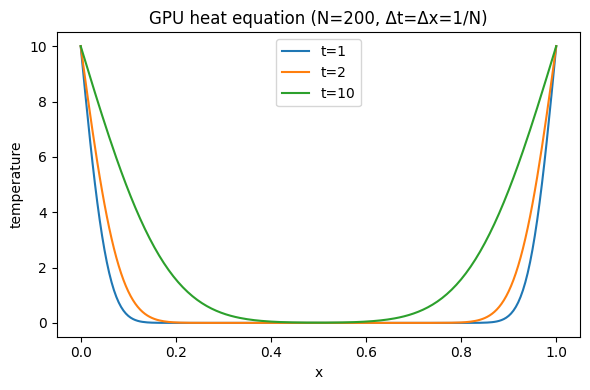

Midpoint first exceeds 9.8 at t ≈ 421.480 (N=200, h=0.00500).


In [ ]:
if __name__ == "__main__":
   N = 200
times = (1.0, 2.0, 10.0)
x, snaps, t_cross, h, T_sim = heat_gpu(N, times=times, threshold=9.8, T_stop=800.0)

# Plot at t=1, 2, 10
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
for T in times:
    plt.plot(x, snaps[T], label=f"t={T:g}")
plt.xlabel("x"); plt.ylabel("temperature")
plt.title(f"GPU heat equation (N={N}, Δt=Δx=1/N)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot the time when the temperature of the midpoint first exceeds 9.8
if t_cross is None:
    print(f"Midpoint did not exceed 9.8 up to T_stop={T_sim:.1f}.")
else:
    print(f"Midpoint first exceeds 9.8 at t ≈ {t_cross:.3f} (N={N}, h={h:.5f}).")


1. How I picked $N$:

I set $N=200$ so that $\Delta x=\Delta t=1/N$ can provide a smooth spatial profile while keeping the explicit update affordable. It is also within the stability range of the FTCS scheme for $D=1/1000$ ($N\le 500$).

2. How I estimate midpoint time to 9.8:

At every time step a tiny kernel writes the midpoint temperature to a device scalar, which I copy back to the host; when it first exceeds $9.8$, record $t=(j+1),\Delta t$. With $N=200$,  I obtain $t\approx 421.480$, which matches the slow diffusion expected for $D=1/1000$.